# Recycling Labs Framework From Libs

In [2]:
from src.preprocessing import clean_func, spacy_preprocess_reviews
from src.sts import STSAnalyzer
from src.models import BaselineModel
import numpy as np
from nltk.metrics import jaccard_distance
import os
import pandas as pd
# IMport partial
import nltk

from functools import partial
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk import ngrams
brown_ic = wordnet_ic.ic('ic-brown.dat')
from nltk import download
from nltk.stem import PorterStemmer

download('averaged_perceptron_tagger')
download('wordnet')
download('omw-1.4')
download('punkt')

import spacy
nlp = spacy.load("en_core_web_sm")
from spacy_wordnet.wordnet_annotator import WordnetAnnotator 
# Load a spaCy model (supported languages are "es" and "en") 
nlp = spacy.load('en_core_web_sm')
# spaCy 3.x
nlp.add_pipe("spacy_wordnet", after='tagger')

import textdistance
from src.fe_utils import *

prep_func = partial(spacy_preprocess_reviews, clean_func=clean_func, out_set=False)
INPUT_FOLDER = "input"
TRAIN_PATH = os.path.join(INPUT_FOLDER, "train")
TEST_PATH = os.path.join(INPUT_FOLDER, "test")
LS_FILES_TRAIN = ["MSRpar", "MSRvid", "SMTeuroparl"]
LS_FILES_TEST = ["MSRpar", "MSRvid", "SMTeuroparl", "surprise.SMTnews", "surprise.OnWN"]


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alberto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/alberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alberto/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/alberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alberto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/alberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alberto/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-dat

## STS Analyzer

In [3]:
import pandas as pd
sts = STSAnalyzer(preprocess_fun=prep_func, model=BaselineModel(),
                  ls_files=LS_FILES_TRAIN, input_path=TRAIN_PATH)
df = sts.load_data()

In [16]:
class FeatureExtractor:
    def __init__(self, prep_func=prep_func, clean_func=clean_func):
        self.prep_func = prep_func
        self.clean_func = clean_func
                 
    def fit(self, df, documents=None):

        prep_func = self.prep_func
        clean_func = self.clean_func

        print("Building auxiliary dataframes...")
        ## BUILD NECESSARY DATAFRAMES
        # Preprocess using spacy and clean and return lists
        print("- Tokenized (list)")
        df_prep_ls = df[["sent1", "sent2"]].copy()
        df_prep_ls["sent1"] = df_prep_ls["sent1"].apply(lambda x: prep_func(x, out_set=False))
        df_prep_ls["sent2"] = df_prep_ls["sent2"].apply(lambda x: prep_func(x, out_set=False))
        
        print("- Tokenized (set)")
        # Preprocess using spacy and clean and return sets
        df_prep = df_prep_ls.copy()
        df_prep["sent1"] = df_prep_ls["sent1"].apply(lambda x: set(x))
        df_prep["sent2"] = df_prep["sent2"].apply(lambda x: set(x))
        
        print("- Clean Strings")
        # Clean and return strings
        df_clean = df[["sent1", "sent2"]].copy()
        df_clean["sent1"] = df_clean["sent1"].apply(lambda x: clean_func(x))
        df_clean["sent2"] = df_clean["sent2"].apply(lambda x: clean_func(x))

        print("- Synsets")
        # Get synsets for each token
        df_synsets = df[['sent1', 'sent2']].copy()
        df_synsets = df_synsets.map(lambda x: [(token.text, token._.wordnet.synsets()) for token in nlp(x)
                                                if not token.is_stop and not token.is_punct 
                                                and not token.is_space])
        
        print("- Stopwords")
        df_stops = df_clean[["sent1", "sent2"]].copy()
        df_stops["sent1"] = df_stops["sent1"].apply(lambda x: [token.text for token in nlp(x) if token.is_stop and not token.is_punct])
        df_stops["sent2"] = df_stops["sent2"].apply(lambda x: [token.text for token in nlp(x) if token.is_stop and not token.is_punct])

        print("- Porter Stemmer")
        df_stem = df_prep[["sent1", "sent2"]].copy()
        df_stem = df_stem.map(lambda x: {PorterStemmer().stem(xx) for xx in x})

        print("\n")
        print("Building features...")
        ## BUILD FEATURES

        # df_features = pd.DataFrame(df["file"].values, columns=["file"])
        df_features = pd.DataFrame()

        print("- String Similarities")
        # Get String Similarities (df_clean strings)
        df_textdistance = get_textdistance_similarities(df_clean)
        if len(df_features.columns.intersection(df_textdistance.columns)) == 0:
            df_features = pd.concat([df_features, df_textdistance], axis=1)

        print("- N-Grams Similarities")
        # Get N-Grams Similarities (df_clean strings)
        
        print("---- Use wordnet as a tokenizer")
        # ---- Use wordnet as a tokenizer
        df_ngram_sim = get_ngrams_similarities(df_clean)

        if len(df_features.columns.intersection(df_ngram_sim.columns)) == 0:
            df_features = pd.concat([df_features, df_ngram_sim], axis=1)
        
        print("---- Use spacy preprocessed as a tokenizer")
        # ---- Use spacy preprocessed data as tokens
        df_ngram_sim_spacy = get_ngrams_similarities(df_prep_ls, tokenize=False)
        df_ngram_sim_spacy.columns = [col + "_spacy" for col in df_ngram_sim_spacy.columns]

        if len(df_features.columns.intersection(df_ngram_sim_spacy.columns)) == 0:
            df_features = pd.concat([df_features, df_ngram_sim_spacy], axis=1)

        # Get Wordnet Similarities (df_synsets)
        
        print("- Wordnet Semantic Similarities")
        # These are the documents to calculate the idf. In case of train, we don't have
        # to provide it, since it will be calculated from the train data. In case of test,
        # we have to provide it, since we don't have the train data.
        
        if documents is None:
            print("---- IDF Calculation")
            documents = df_prep["sent1"].tolist() + df_prep["sent2"].tolist()

        print("---- IDF Weighted")
        # Calculate similarities, weight them with idf and average forward and backwards
        # this is mainly for asymetric similarities like Wu Palmer
        df_sem_sim = get_sem_similarities(df_synsets, idf=True, documents=documents)
        df_sem_sim.columns = [col + "_idf" for col in df_sem_sim.columns]
    
        if len(df_sem_sim.columns.intersection(df_features.columns)) == 0:
            df_features = pd.concat([df_features, df_sem_sim], axis=1)

        print("---- NON IDF Weighted")
        # Do the same without idf
        df_sem_sim_not_idf = get_sem_similarities(df_synsets, idf=False)
        if len(df_features.columns.intersection(df_sem_sim_not_idf.columns)) == 0:
            df_features = pd.concat([df_features, df_sem_sim_not_idf], axis=1)

        print("---- Similarity Stopwords")
        df_ngram_stop = get_ngrams_similarities(df_stops, tokenize=False)
        df_ngram_stop.columns = [col + "_stop" for col in df_ngram_stop.columns]
        
        if len(df_features.columns.intersection(df_ngram_stop.columns)) == 0:
            df_features = pd.concat([df_features, df_ngram_stop], axis=1)

        print("---- Porter Stemmer")
        # Get ngram distances for Porter Stemmer
        df_ngram_stem = get_ngrams_similarities(df_stem, tokenize=False)
        df_ngram_stem.columns = [col + "_stem" for col in df_ngram_stem.columns]

        if len(df_features.columns.intersection(df_ngram_stem.columns)) == 0:
            df_features = pd.concat([df_features, df_ngram_stem], axis=1)

        self.documents = documents
        return df_features
    
    def transform(self, df):
        return self.fit(df, documents=self.documents)
    

In [17]:
sts_test = STSAnalyzer(preprocess_fun=prep_func, model=BaselineModel(),
                    ls_files=LS_FILES_TEST, input_path=TEST_PATH)
df_test = sts_test.load_data()

In [18]:
fe = FeatureExtractor()
df_features_train = fe.fit(df.sample(20))
df_features_test = fe.transform(df_test.sample(15))

Building auxiliary dataframes...
- Tokenized (list)
- Tokenized (set)
- Clean Strings
- Synsets
- Stopwords
- Porter Stemmer


Building features...
- String Similarities
- N-Grams Similarities
---- Use wordnet as a tokenizer
---- Use spacy preprocessed as a tokenizer
- Wordnet Semantic Similarities
---- IDF Calculation
---- IDF Weighted
---- NON IDF Weighted
---- Similarity Stopwords
---- Porter Stemmer
Building auxiliary dataframes...
- Tokenized (list)
- Tokenized (set)
- Clean Strings
- Synsets
- Stopwords
- Porter Stemmer


Building features...
- String Similarities
- N-Grams Similarities
---- Use wordnet as a tokenizer
---- Use spacy preprocessed as a tokenizer
- Wordnet Semantic Similarities
---- IDF Weighted
---- NON IDF Weighted
---- Similarity Stopwords
---- Porter Stemmer


In [20]:
def write_train_test(name, df, df_test):
    print(f"Creating {name} features...")
    if name == "all":
        df_ = df.copy()
        df_test_ = df_test.copy()
    else:
        df_ = df[df["file"] == name].copy()
        df_test_ = df_test[df_test["file"] == name].copy()

    fe_all = FeatureExtractor()
    df_features_train = fe_all.fit(df_)
    df_features_train["file"] = df_["file"]
    df_features_train["gs"] = df_["gs"]
    df_features_train.to_csv(f"features/{name}_features_train.csv", index=False)
    df_features_test = fe_all.transform(df_test_)
    df_features_test["file"] = df_test_["file"]
    df_features_test["gs"] = df_test_["gs"]
    df_features_test.to_csv(f"features/{name}_features_test.csv", index=False)

write_train_test("all", df, df_test)

Creating all features...
Building auxiliary dataframes...
- Tokenized (list)
- Tokenized (set)
- Clean Strings
- Synsets
- Stopwords
- Porter Stemmer


Building features...
- String Similarities
- N-Grams Similarities
---- Use wordnet as a tokenizer
---- Use spacy preprocessed as a tokenizer
- Wordnet Semantic Similarities
---- IDF Calculation
---- IDF Weighted
---- NON IDF Weighted
---- Similarity Stopwords
---- Porter Stemmer
Building auxiliary dataframes...
- Tokenized (list)
- Tokenized (set)
- Clean Strings
- Synsets
- Stopwords
- Porter Stemmer


Building features...
- String Similarities
- N-Grams Similarities
---- Use wordnet as a tokenizer
---- Use spacy preprocessed as a tokenizer
- Wordnet Semantic Similarities
---- IDF Weighted
---- NON IDF Weighted
---- Similarity Stopwords
---- Porter Stemmer


In [21]:
write_train_test("MSRpar", df, df_test)
write_train_test("MSRvid", df, df_test)
write_train_test("SMTeuroparl", df, df_test)

Creating MSRpar features...
Building auxiliary dataframes...
- Tokenized (list)
- Tokenized (set)
- Clean Strings
- Synsets
- Stopwords
- Porter Stemmer


Building features...
- String Similarities
- N-Grams Similarities
---- Use wordnet as a tokenizer
---- Use spacy preprocessed as a tokenizer
- Wordnet Semantic Similarities
---- IDF Calculation
---- IDF Weighted
---- NON IDF Weighted
---- Similarity Stopwords
---- Porter Stemmer
Building auxiliary dataframes...
- Tokenized (list)
- Tokenized (set)
- Clean Strings
- Synsets
- Stopwords
- Porter Stemmer


Building features...
- String Similarities
- N-Grams Similarities
---- Use wordnet as a tokenizer
---- Use spacy preprocessed as a tokenizer
- Wordnet Semantic Similarities
---- IDF Weighted
---- NON IDF Weighted
---- Similarity Stopwords
---- Porter Stemmer
Creating MSRvid features...
Building auxiliary dataframes...
- Tokenized (list)
- Tokenized (set)
- Clean Strings
- Synsets
- Stopwords
- Porter Stemmer


Building features...
- S

In [ ]:
def write_surprise(name, df, df_test):
    print(f"Creating {name} features...")
    df_ = df[df["file"] == name].copy()
    df_test_ = df_test[df_test["file"] == name].copy()

    fe_all = FeatureExtractor()
    df_features_train = fe_all.fit(df_)
    df_features_train.to_csv(f"features/{name}_features_train.csv", index=False)
    df_features_test = fe_all.transform(df_test_)
    df_features_test.to_csv(f"features/{name}_features_test.csv", index=False)

In [ ]:
print("Creating all features...")
fe_all = FeatureExtractor()
df_features_all_train = fe_all.fit(df, prep_func, clean_func)
df_features_all.to_csv("features/all_features_train.csv", index=False)
df_features_all_test = fe_all.transform(df_test, prep_func, clean_func)
df_features_all.to_csv("features/all_features_test.csv", index=False)

print("Creating MSRpar features...")
fe_par = FeatureExtractor()
df_features_par = fe_par.fit(df[df["file"] == "MSRpar"], prep_func, clean_func)
df_features_par.to_csv("features/msrpar_features_train.csv", index=False)
df_features_par_test = fe_par.transform(df_test[df_test["file"] == "MSRpar"], prep_func, clean_func)
df_features_par_test.to_csv("features/msrpar_features_test.csv", index=False)

print("Creating MSRvid features...")
df_features_vid = get_features(df[df["file"] == "MSRvid"], prep_func, clean_func)
df_features_europarl = get_features(df[df["file"] == "SMTeuroparl"], prep_func, clean_func)

In [8]:
df_features_fun

,file,lcstr,lcseq,gst,jaro,jaro_w,monge,levenshtein,jaccard_n_1,dice_n_1,...,overlap_n_3_stop,cosine_n_3_stop,jaccard_n_4_stop,dice_n_4_stop,overlap_n_4_stop,cosine_n_4_stop,jaccard_n_5_stop,dice_n_5_stop,overlap_n_5_stop,cosine_n_5_stop
0,MSRpar,75,105,0.738007,0.865225,0.919135,0.006369,104,0.548387,0.708333,...,0.363636,0.363636,0.176471,0.300000,0.3,0.300000,0.125000,0.222222,0.222222,0.222222
1,MSRpar,24,53,0.670886,0.738972,0.843383,0.015873,50,0.444444,0.615385,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,MSRpar,27,56,0.464865,0.782203,0.782203,0.010989,39,0.363636,0.533333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,MSRpar,129,133,0.833856,0.901976,0.941186,0.007407,133,0.655172,0.791667,...,1.000000,0.707107,0.428571,0.600000,1.0,0.654654,0.333333,0.500000,1.000000,0.577350
4,MSRpar,20,54,0.507614,0.696501,0.696501,0.009342,44,0.250000,0.400000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,MSRpar,12,46,0.520231,0.647638,0.647638,0.010517,26,0.200000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
6,MSRpar,17,77,0.457516,0.743571,0.743571,0.006711,40,0.411765,0.583333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
7,MSRpar,36,83,0.703390,0.758887,0.758887,0.009804,67,0.592593,0.744186,...,0.500000,0.433013,0.200000,0.333333,0.4,0.338062,0.111111,0.200000,0.250000,0.204124
8,MSRpar,30,76,0.714286,0.737572,0.737572,0.009006,62,0.545455,0.705882,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
9,MSRpar,23,69,0.615385,0.740120,0.844072,0.008850,52,0.423077,0.594595,...,0.200000,0.182574,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


## Get Tokenization

In [10]:
# 0. Preprocess for similarity
df_prep = df.copy()
df_prep["sent1"] = df_prep["sent1"].apply(lambda x: prep_func(x, out_set=True))
df_prep["sent2"] = df_prep["sent2"].apply(lambda x: prep_func(x, out_set=True))
df_prep

,sent1,sent2,gs,file
0,"{asset, bidder, source, keep, individual, team...","{source, day, keep, close, open, say, door, sa...",4.00,MSRpar
1,"{micron, year, declare, quarterly, profit}","{micron, year, manufacturer, number, quarterly...",3.75,MSRpar
2,"{fine, effort, entice, return, fail, democrats...","{fine, effort, return, democrats, back, includ...",2.80,MSRpar
3,"{american, group, anglican, episcopalian, crea...","{action, american, week, anglican, episcopalia...",3.40,MSRpar
4,"{level, end, load, 12, rise, nasdaq, month, co...","{climb, technology, 1.2_%, 19.11, nasdaq, lace...",2.40,MSRpar
...,...,...,...,...
2229,"{action, agenda, need, decide, item, include, ...","{agenda, decide, item, urgent}",5.00,SMTeuroparl
2230,"{improvement, good, wish, start, believe, hone...","{actually, good, well, start, think, want, hon...",4.80,SMTeuroparl
2231,"{parliament, amendment, accept, oral}","{parliament, amendment, accept, oral}",5.00,SMTeuroparl
2232,"{party, consumer, apply, product, standard, re...","{party, regulation, standard, reservation, com...",4.80,SMTeuroparl


In [11]:
df_prep_ls = df.copy()
df_prep_ls["sent1"] = df_prep_ls["sent1"].apply(lambda x: prep_func(x, out_set=False))
df_prep_ls["sent2"] = df_prep_ls["sent2"].apply(lambda x: prep_func(x, out_set=False))
df_prep_ls

,sent1,sent2,gs,file
0,"[source, close, sale, say, vivendi, keep, door...","[source, close, sale, say, vivendi, keep, door...",4.00,MSRpar
1,"[micron, declare, quarterly, profit, year]","[micron, number, mark, quarterly, profit, year...",3.75,MSRpar
2,"[fine, fail, republican, effort, force, entice...","[perry, say, back, senate, effort, include, fi...",2.80,MSRpar
3,"[american, anglican, council, represent, episc...","[american, anglican, council, represent, episc...",3.40,MSRpar
4,"[tech, load, nasdaq, composite, rise, 20.96, p...","[technology, lace, nasdaq, composite, index, i...",2.40,MSRpar
...,...,...,...,...
2229,"[action, need, quickly, decide, include, item,...","[urgent, decide, item, agenda]",5.00,SMTeuroparl
2230,"[wish, improvement, honestly, believe, good, s...","[actually, want, well, think, honestly, good, ...",4.80,SMTeuroparl
2231,"[parliament, accept, oral, amendment]","[parliament, accept, oral, amendment]",5.00,SMTeuroparl
2232,"[party, reservation, community, law, apply, sa...","[party, reservation, regulation, sale, consump...",4.80,SMTeuroparl


# Clean text

In [12]:
df_clean = df.copy()
df_clean["sent1"] = df_clean["sent1"].apply(lambda x: clean_func(x))
df_clean["sent2"] = df_clean["sent2"].apply(lambda x: clean_func(x))
df_clean

,sent1,sent2,gs,file
0,but other sources close to the sale said viven...,but other sources close to the sale said viven...,4.00,MSRpar
1,micron has declared its first quarterly profit...,micron numbers also marked the first quarterly...,3.75,MSRpar
2,the fines are part of failed republican effort...,"perry said he backs the senate efforts, includ...",2.80,MSRpar
3,"the american anglican council, which represent...","the american anglican council, which represent...",3.40,MSRpar
4,the tech-loaded nasdaq composite rose 20.96 po...,the technology-laced nasdaq composite index ix...,2.40,MSRpar
...,...,...,...,...
2229,"action is needed quickly, which is why we deci...",it is urgent and that is why we have decided t...,5.00,SMTeuroparl
2230,one could indeed wish for more and for improve...,"we can actually want more and better, but i th...",4.80,SMTeuroparl
2231,(parliament accepted the oral amendment),(parliament accepted the oral amendment),5.00,SMTeuroparl
2232,- my party has serious reservations about comm...,my party serious reservations about the regula...,4.80,SMTeuroparl


## Get Synsets

In [13]:
# Calculate Synsets
df_synsets = df[['sent1', 'sent2']].copy()
df_synsets = df_synsets.map(lambda x: [(token.text, token._.wordnet.synsets()) for token in nlp(x)
                    if not token.is_stop and not token.is_punct 
                    and not token.is_space])

df_synsets.head()

KeyboardInterrupt: 

# DF Stopwords

In [40]:
df_stops = df_clean[["sent1", "sent2"]].copy()
df_stops["sent1"] = df_stops["sent1"].apply(lambda x: [token.text for token in nlp(x) if token.is_stop and not token.is_punct])
df_stops["sent2"] = df_stops["sent2"].apply(lambda x: [token.text for token in nlp(x) if token.is_stop and not token.is_punct])
df_stops

,sent1,sent2
0,"[but, other, to, the, was, the, to, further, a...","[but, other, to, the, was, the, for, further, ..."
1,"[has, its, first, for, three]","[also, the, first, in, three, for, the]"
2,"[the, are, part, of, to, or, the, to]","[he, the, the, to, the, to]"
3,"[the, which, it, will, to, a]","[the, which, it, will, to, a, in, because, of,..."
4,"[the, to, at, its, for]","[the, or, to]"
...,...,...
2229,"[is, which, is, why, we, to, this, on, the]","[it, is, and, that, is, why, we, have, to, put..."
2230,"[one, could, indeed, for, more, and, for, but,...","[we, can, more, and, but, i, quite, that, it, ..."
2231,[the],[the]
2232,"[my, has, serious, about, to, the, of, as, aga...","[my, serious, about, the, of, the, of, by, of,..."


# Stemmed words (Lemma+Porter)

In [21]:
df_stem = df_prep[["sent1", "sent2"]].iloc[:10].copy()
df_stem = df_stem.map(lambda x: {PorterStemmer().stem(xx) for xx in x})

In [22]:
df_stem

,sent1,sent2
0,"{asset, bidder, individu, keep, vivendi, team,...","{keep, vivendi, sourc, close, bid, open, say, ..."
1,"{micron, year, declar, quarterli, profit}","{micron, year, profit, manufactur, quarterli, ..."
2,"{entic, fine, effort, forc, return, fail, demo...","{fine, effort, forc, senat, return, back, say,..."
3,"{american, author, group, anglican, episcopali...","{action, american, author, week, anglican, epi..."
4,"{level, end, load, 12, composit, rise, nasdaq,...","{climb, 1.2_%, 19.11, composit, technolog, nas..."
5,"{gain, 1.45_%, 65.05, amgen, trade, share, nas...","{exchang, 14, york, stock, trade, allergan, sh..."
6,"{17, crackdown, individu, prosecutor, 130, con...","{17, peopl, properti, sweep, 130, govern, anno..."
7,"{resolv, chavez, investig, feel, confid, regar...","{resolv, mayor, chavez, investig, albuquerqu, ..."
8,"{author, home, scientist, quarantin, sar, 10, ...","{home, scientist, quarantin, sar, soon, sympto..."
9,"{contract, free, come, upgrad, custom, softwar...","{2004, free, smarnet, januari, upgrad, avail, ..."


# Porter n_grams

In [23]:
df_features = df_features_fun.copy()
df_features

,file,lcstr,lcseq,gst,jaro,jaro_w,monge,levenshtein,jaccard_n_1,dice_n_1,...,overlap_n_3_stop,cosine_n_3_stop,jaccard_n_4_stop,dice_n_4_stop,overlap_n_4_stop,cosine_n_4_stop,jaccard_n_5_stop,dice_n_5_stop,overlap_n_5_stop,cosine_n_5_stop
0,MSRpar,75,105,0.738007,0.865225,0.919135,0.006369,104,0.548387,0.708333,...,0.363636,0.363636,0.176471,0.300000,0.3,0.300000,0.125000,0.222222,0.222222,0.222222
1,MSRpar,24,53,0.670886,0.738972,0.843383,0.015873,50,0.444444,0.615385,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,MSRpar,27,56,0.464865,0.782203,0.782203,0.010989,39,0.363636,0.533333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,MSRpar,129,133,0.833856,0.901976,0.941186,0.007407,133,0.655172,0.791667,...,1.000000,0.707107,0.428571,0.600000,1.0,0.654654,0.333333,0.500000,1.000000,0.577350
4,MSRpar,20,54,0.507614,0.696501,0.696501,0.009342,44,0.250000,0.400000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,MSRpar,12,46,0.520231,0.647638,0.647638,0.010517,26,0.200000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
6,MSRpar,17,77,0.457516,0.743571,0.743571,0.006711,40,0.411765,0.583333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
7,MSRpar,36,83,0.703390,0.758887,0.758887,0.009804,67,0.592593,0.744186,...,0.500000,0.433013,0.200000,0.333333,0.4,0.338062,0.111111,0.200000,0.250000,0.204124
8,MSRpar,30,76,0.714286,0.737572,0.737572,0.009006,62,0.545455,0.705882,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
9,MSRpar,23,69,0.615385,0.740120,0.844072,0.008850,52,0.423077,0.594595,...,0.200000,0.182574,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
df_ngram_sim_porter = get_ngrams_similarities(df_stem, tokenize=False)
df_ngram_sim_porter.columns = [col + "_lemma_porter" for col in df_ngram_sim_porter.columns]
df_ngram_sim_porter

,jaccard_n_1_lemma_porter,dice_n_1_lemma_porter,overlap_n_1_lemma_porter,cosine_n_1_lemma_porter,jaccard_n_2_lemma_porter,dice_n_2_lemma_porter,overlap_n_2_lemma_porter,cosine_n_2_lemma_porter,jaccard_n_3_lemma_porter,dice_n_3_lemma_porter,overlap_n_3_lemma_porter,cosine_n_3_lemma_porter,jaccard_n_4_lemma_porter,dice_n_4_lemma_porter,overlap_n_4_lemma_porter,cosine_n_4_lemma_porter,jaccard_n_5_lemma_porter,dice_n_5_lemma_porter,overlap_n_5_lemma_porter,cosine_n_5_lemma_porter
0,0.562500,0.720000,0.900000,0.734847,0.210526,0.347826,0.444444,0.356348,0.050000,0.095238,0.125000,0.098058,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000000
1,0.444444,0.615385,0.800000,0.632456,0.100000,0.181818,0.250000,0.188982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000000
2,0.384615,0.555556,0.625000,0.559017,0.142857,0.250000,0.285714,0.251976,0.076923,0.142857,0.166667,0.144338,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000000
3,0.647059,0.785714,0.916667,0.793857,0.300000,0.461538,0.545455,0.467099,0.142857,0.250000,0.300000,0.253546,0.100000,0.181818,0.222222,0.184900,0.052632,0.1,0.125,0.102062
4,0.142857,0.250000,0.272727,0.250873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000000
5,0.166667,0.285714,0.300000,0.286039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000000
6,0.380952,0.551724,0.615385,0.554700,0.125000,0.222222,0.250000,0.223607,0.086957,0.160000,0.181818,0.161165,0.045455,0.086957,0.100000,0.087706,0.000000,0.0,0.000,0.000000
7,0.538462,0.700000,0.777778,0.703526,0.200000,0.333333,0.375000,0.335410,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000000
8,0.538462,0.700000,0.777778,0.703526,0.285714,0.444444,0.500000,0.447214,0.142857,0.250000,0.285714,0.251976,0.076923,0.142857,0.166667,0.144338,0.000000,0.0,0.000,0.000000
9,0.333333,0.500000,0.500000,0.500000,0.058824,0.111111,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000000


In [26]:
df_features

,file,lcstr,lcseq,gst,jaro,jaro_w,monge,levenshtein,jaccard_n_1,dice_n_1,...,overlap_n_3_stop,cosine_n_3_stop,jaccard_n_4_stop,dice_n_4_stop,overlap_n_4_stop,cosine_n_4_stop,jaccard_n_5_stop,dice_n_5_stop,overlap_n_5_stop,cosine_n_5_stop
0,MSRpar,75,105,0.738007,0.865225,0.919135,0.006369,104,0.548387,0.708333,...,0.363636,0.363636,0.176471,0.300000,0.3,0.300000,0.125000,0.222222,0.222222,0.222222
1,MSRpar,24,53,0.670886,0.738972,0.843383,0.015873,50,0.444444,0.615385,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,MSRpar,27,56,0.464865,0.782203,0.782203,0.010989,39,0.363636,0.533333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,MSRpar,129,133,0.833856,0.901976,0.941186,0.007407,133,0.655172,0.791667,...,1.000000,0.707107,0.428571,0.600000,1.0,0.654654,0.333333,0.500000,1.000000,0.577350
4,MSRpar,20,54,0.507614,0.696501,0.696501,0.009342,44,0.250000,0.400000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,MSRpar,12,46,0.520231,0.647638,0.647638,0.010517,26,0.200000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
6,MSRpar,17,77,0.457516,0.743571,0.743571,0.006711,40,0.411765,0.583333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
7,MSRpar,36,83,0.703390,0.758887,0.758887,0.009804,67,0.592593,0.744186,...,0.500000,0.433013,0.200000,0.333333,0.4,0.338062,0.111111,0.200000,0.250000,0.204124
8,MSRpar,30,76,0.714286,0.737572,0.737572,0.009006,62,0.545455,0.705882,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
9,MSRpar,23,69,0.615385,0.740120,0.844072,0.008850,52,0.423077,0.594595,...,0.200000,0.182574,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

vec = TfidfVectorizer()
df_prep_ls_aux = df_prep_ls.copy()
df_prep_ls_aux["sent1"] = df_prep_ls_aux["sent1"].apply(lambda x: " ".join(x))
df_prep_ls_aux["sent2"] = df_prep_ls_aux["sent2"].apply(lambda x: " ".join(x))

vec.fit(df_prep_ls_aux["sent1"].tolist() + df_prep_ls_aux["sent2"].tolist())
df_tfidf_1 = pd.DataFrame(vec.transform(df_prep_ls_aux["sent1"]).todense())
df_tfidf_2 = pd.DataFrame(vec.transform(df_prep_ls_aux["sent2"]).todense())

pca = PCA(n_components=.9)
sc = StandardScaler()
df_tfidf_1 = sc.fit_transform(pca.fit_transform(sc.fit_transform(df_tfidf_1)))
df_tfidf_2 = sc.fit_transform(pca.fit_transform(sc.fit_transform(df_tfidf_2)))

dim = np.min([df_tfidf_1.shape[1], df_tfidf_2.shape[1]])
df_tfidf_1 = df_tfidf_1[:, :dim]
df_tfidf_2 = df_tfidf_2[:, :dim]

# calculate cosine similarity per row

from numpy.linalg import norm
cos_sim = [np.dot(x,y)/(norm(x)*norm(y))for x, y in zip(df_tfidf_1, df_tfidf_2)]


In [25]:

df_corr = pd.concat([df_features, df_prep["gs"]], axis=1)

# Plot heatmap of correlations
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_corr = pd.DataFrame(sc.fit_transform(df_corr), columns=df_corr.columns)
plt.figure(figsize=(5, 20))
sns.heatmap(df_corr.corr()[["gs"]].sort_values(by="gs", ascending=False), annot=True, cmap="coolwarm", label="big",
            vmin=-1, vmax=1)
plt.show()


KeyError: "None of [Index(['gs'], dtype='object')] are in the [columns]"

<Figure size 500x2000 with 0 Axes>

In [ ]:
df_feats_par = df_features[df["file"] == "MSRpar"]
df_feats_vid = df_features[df["file"] == "MSRvid"]
df_feats_euro = df_features[df["file"] == "SMTeuroparl"]

y_par = df[df["file"] == "MSRpar"]["gs"]
y_vid = df[df["file"] == "MSRvid"]["gs"]
y_euro = df[df["file"] == "SMTeuroparl"]["gs"]

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr

rf_par= RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, min_samples_leaf=6)

# Create a scorer usin pearson correlation
pearson_scorer = make_scorer(lambda x, y: pearsonr(x, y).statistic)

scores_par = cross_val_score(rf_par, df_feats_par, y_par, cv=10, scoring=pearson_scorer)
rf_par.fit(df_feats_par, y_par)
print("Pearson correlation: %0.2f (+/- %0.2f)" % (scores_par.mean(), scores_par.std() * 2))

Pearson correlation: 0.66 (+/- 0.11)


In [57]:
rf_vid = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, min_samples_leaf=6)

# Create a scorer usin pearson correlation
pearson_scorer = make_scorer(lambda x, y: pearsonr(x, y).statistic)

scores_vid = cross_val_score(rf_vid, df_feats_vid, y_vid, cv=10, scoring=pearson_scorer)
rf_vid.fit(df_feats_vid, y_vid)
print("Pearson correlation: %0.2f (+/- %0.2f)" % (scores_vid.mean(), scores_vid.std() * 2))

Pearson correlation: 0.81 (+/- 0.07)


In [63]:
rf_euro = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, min_samples_leaf=3)

# Create a scorer usin pearson correlation
pearson_scorer = make_scorer(lambda x, y: pearsonr(x, y).statistic)

scores_euro = cross_val_score(rf_euro, df_feats_euro, y_euro, cv=10, scoring=pearson_scorer)
rf_euro.fit(df_feats_euro, y_euro)
print("Pearson correlation: %0.2f (+/- %0.2f)" % (scores_euro.mean(), scores_euro.std() * 2))

Pearson correlation: 0.70 (+/- 0.29)


In [64]:
scores_euro

array([0.71083292, 0.58067859, 0.83537188, 0.89908301, 0.7803359 ,
       0.41436774, 0.62335735, 0.74882944, 0.56660093, 0.85696031])

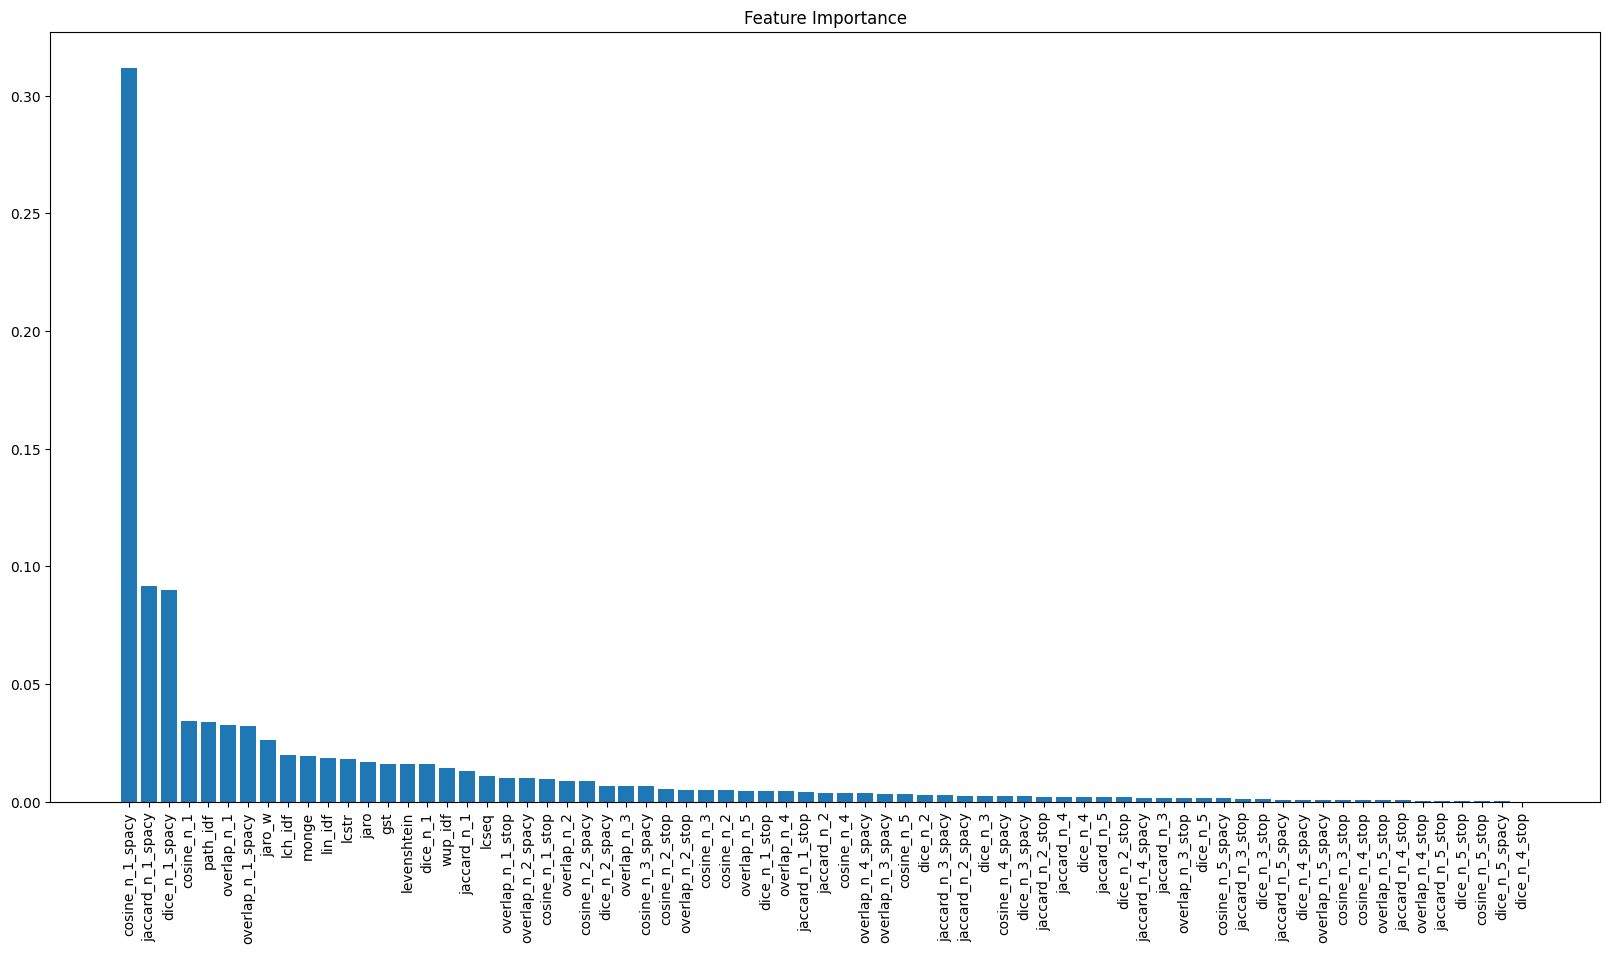

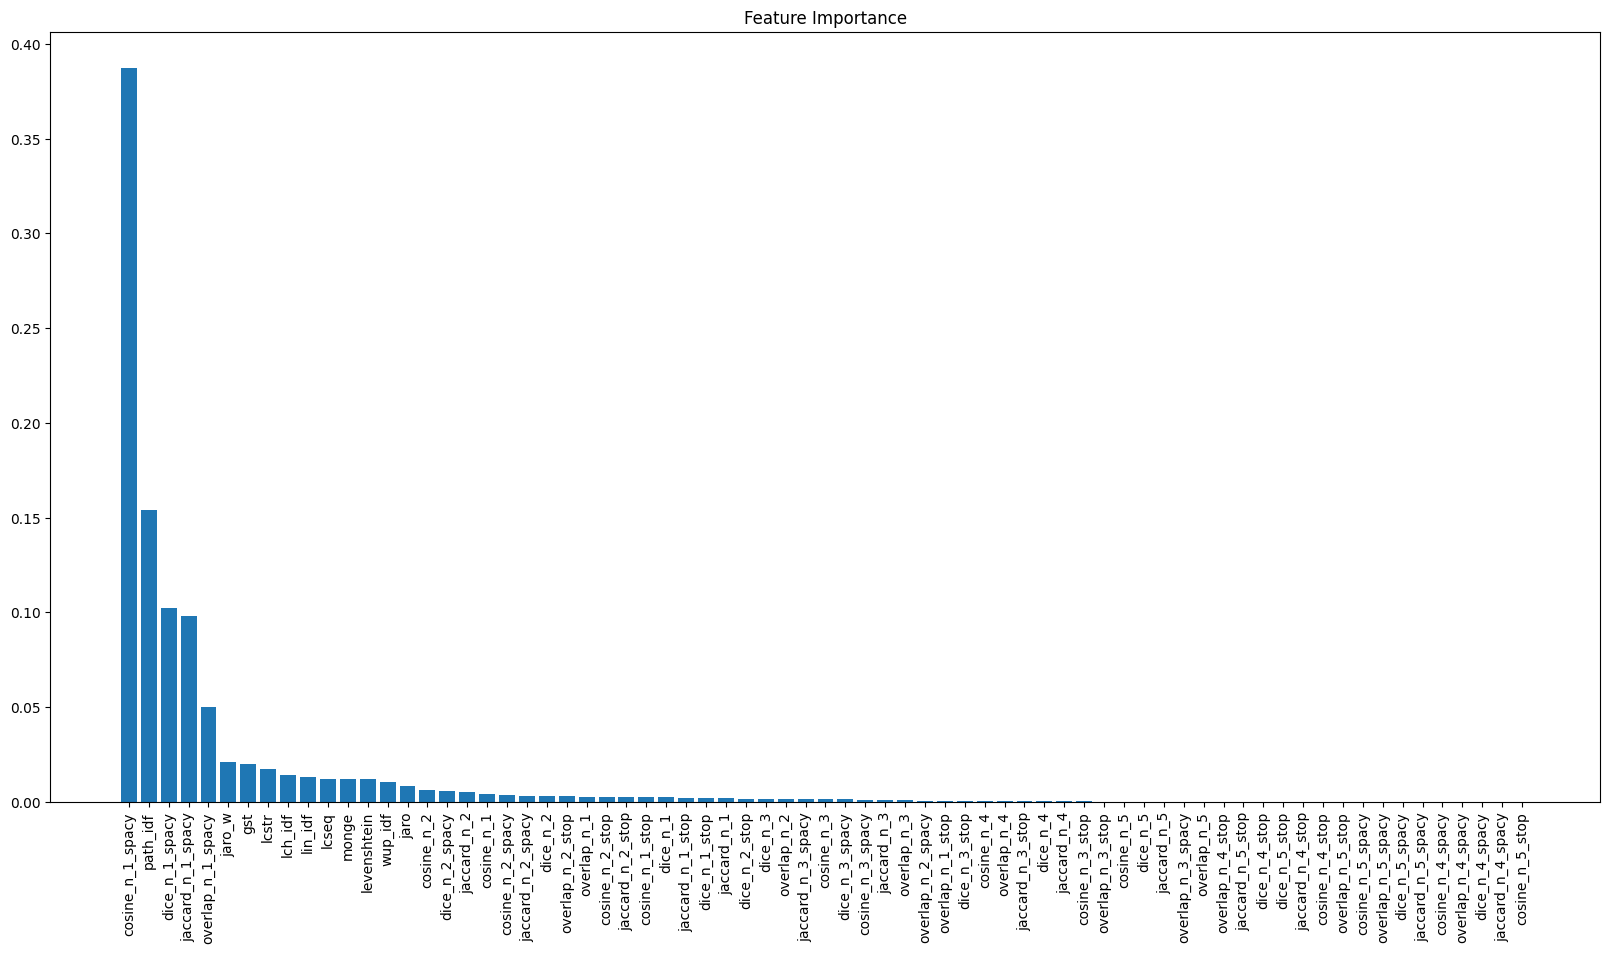

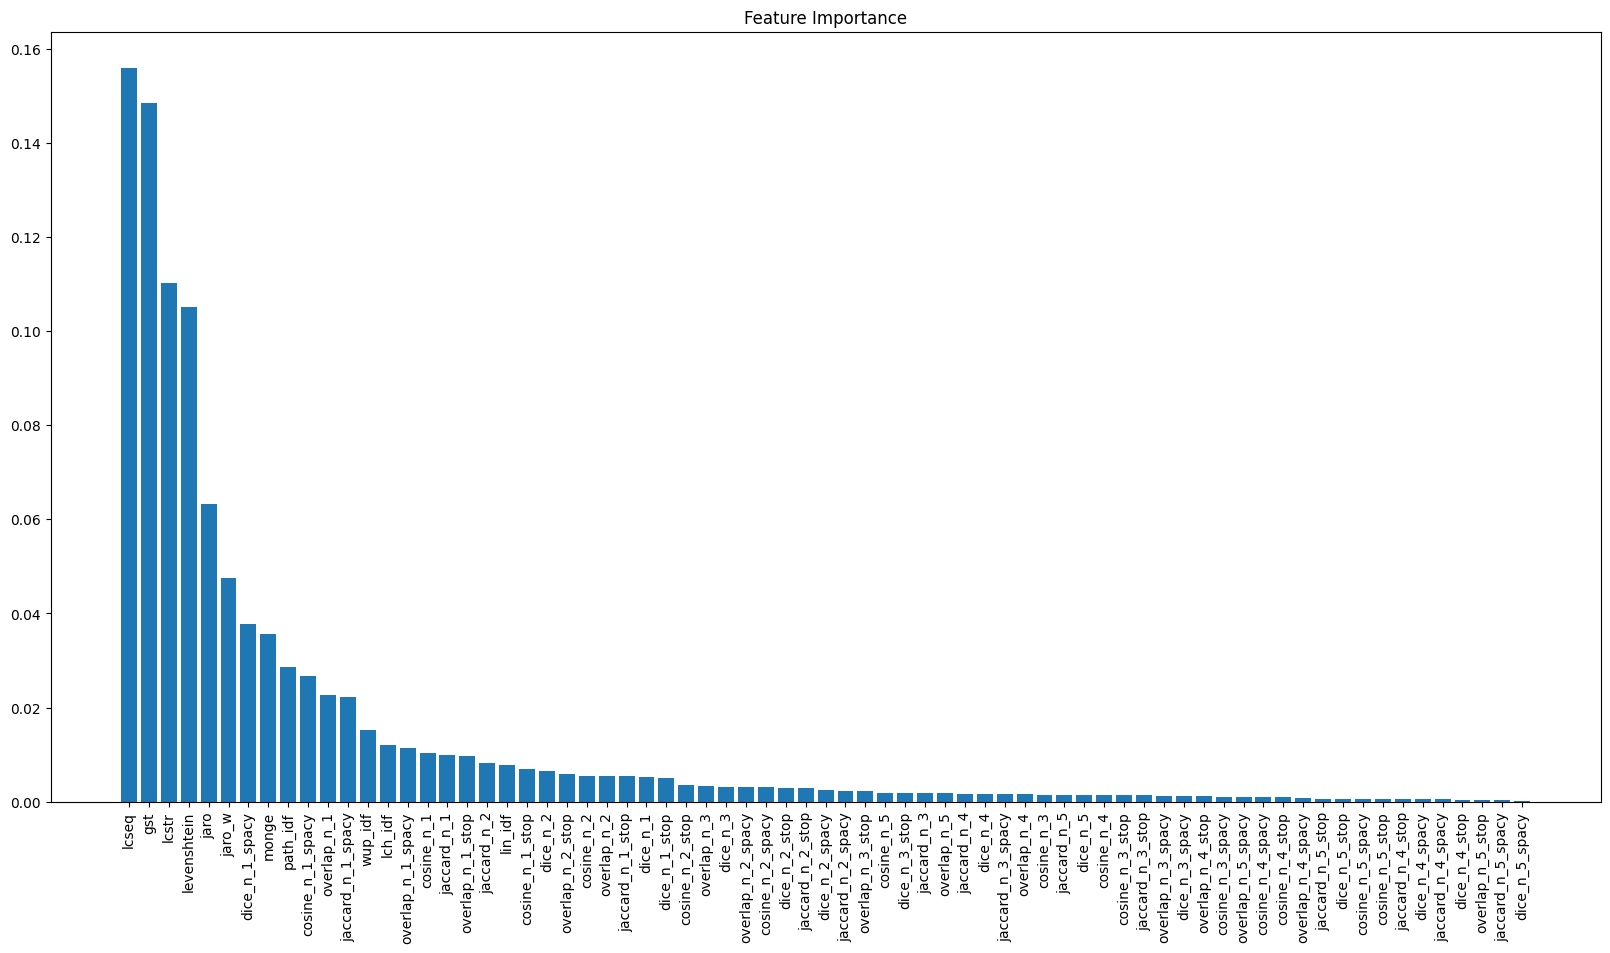

In [65]:
# Create a function receiving a trained rf and plots the feature importances
def plot_feature_importances(rf, df):
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [df.columns[i] for i in indices]
    plt.figure(figsize=(20, 10))
    plt.title("Feature Importance")
    plt.bar(range(df.shape[1]), importances[indices])
    plt.xticks(range(df.shape[1]), names, rotation=90)
    plt.show()

plot_feature_importances(rf_par, df_feats_par)
plot_feature_importances(rf_vid, df_feats_vid)

plot_feature_importances(rf_euro, df_feats_euro)

In [ ]:
# import umap
# reduce = umap.UMAP()